# Отток клиентов

**Описание проекта**

Оператор связи хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. 

**Цель проекта**

Обучить модель, которая будет предсказывать, разорвёт ли абонент договор.

**Ход проекта**
1. Загрузка данных;
2. Предобработка данных;
3. Объединение данных;
4. Исследовательский анализ и предобработка данных объединённого датафрейма;
5. Подготовка данных для обучения модели;
6. Обучение моделей машинного обучения;
7. Выбор лучшей модели;
8. Общий вывод и рекомендации заказчику.

## Загрузка данных

### Импорт библиотек

In [1]:
!pip install scikit-learn==1.1.3 -q

In [2]:
!pip install matplotlib==3.7.0 -q

In [3]:
!pip install phik shap -q

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import seaborn as sns
import shap

RANDOM_STATE = 201025
TEST_SIZE = 0.25

### Загрузка и обзор данных

Данные состоят из нескольких файлов, полученных из разных источников. Загрузим файлы.

In [5]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

Выполним обзор данных.

In [6]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Файл **contract**_new.csv содержит информацию о договоре:
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

In [7]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Файл **personal**_new.csv содержит персональные данные клиента:
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

In [8]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Файл **internet**_new.csv содержит информацию об интернет-услугах:
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

In [9]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Файл **phone**_new.csv содержит информацию об услугах cтационарной телефонной связи:
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

Вывдем общую информацию о данных.

In [10]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Датафрейм **contract** содержит 8 столбцов и 7 043 строки. Пропусков нет, типы данных соответствуют, но не везде. Необходимо будет перевести столбцы BeginDate и EndDate в тип даты, а столбец TotalCharges в тип float64.

In [11]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Датафрейм **personal** содержит 5 столбцов и 7 043 строки. Пропусков нет, типы данных соответствуют, но не везде. Необходимо будет перевести столбец SeniorCitizen в тип object, так как это категориальный признак.

In [12]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Датафрейм **internet** содержит 8 столбцов и 5 517 строк. Пропусков нет, типы данных соответствуют.

In [13]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Датафрейм **phone** содержит 2 столбца и 6 261 строку. Пропусков нет, типы данных соответствуют.

Таким образом, предоставлены данные о 7 043 клиентах оператора - кол-во наблюдений в датафреймах о заключенных договорах и персональных данных совпадают. При этом услугами интернета пользуются 5 517 клиентов, а услугами телефонии - 6 261. Это означает, что один клиент может не только иметь подключение либо интернета, либо телефонии, но и иметь подключение обеих услуг одновременно.

В датафрейме **contract** проверим неявные дубликаты.

In [14]:
cat_columns = ['Type', 'PaperlessBilling', 'PaymentMethod']

for column in cat_columns:
    print(contract[column].value_counts())
    print()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64



Неявные дубликаты отсутствуют.

В датафрейме **personal** проверим неявные дубликаты.

In [15]:
cat_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

for column in cat_columns:
    print(personal[column].value_counts())
    print()

Male      3555
Female    3488
Name: gender, dtype: int64

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

No     3641
Yes    3402
Name: Partner, dtype: int64

No     4933
Yes    2110
Name: Dependents, dtype: int64



Неявные дубликаты отсутствуют.

В датафрейме **internet** проверим неявные дубликаты.

In [16]:
cat_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
               'TechSupport', 'StreamingTV', 'StreamingMovies']

for column in cat_columns:
    print(internet[column].value_counts())
    print()

Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64

No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64

No     3088
Yes    2429
Name: OnlineBackup, dtype: int64

No     3095
Yes    2422
Name: DeviceProtection, dtype: int64

No     3473
Yes    2044
Name: TechSupport, dtype: int64

No     2810
Yes    2707
Name: StreamingTV, dtype: int64

No     2785
Yes    2732
Name: StreamingMovies, dtype: int64



Неявные дубликаты отсутствуют.

В датафрейме **phone** проверим неявные дубликаты.

In [17]:
phone['MultipleLines'].value_counts()

No     3390
Yes    2971
Name: MultipleLines, dtype: int64

Неявные дубликаты отсутствуют.

Проверим наличие явных дубликатов.

In [18]:
df_list = [contract, personal, internet, phone]

for df in df_list:
    print(df.duplicated().sum())
    print()

0

0

0

0



Явных дубликатов нет.

### Выводы

Предоставленные данные содержатся в четырех датафреймах:
- contract — информация о договоре;
- personal — персональные данные клиента;
- internet — информация об интернет-услугах;
- phone — информация об услугах телефонии.

Датафрейм **contract** содержит информацию о договоре:
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Датафрейм **personal** содержит персональные данные клиента:
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Датафрейм **internet** содержит информацию об интернет-услугах:
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Датафрейм **phone** содержит информацию об услугах cтационарной телефонной связи:
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

Датафрейм **contract** содержит 8 столбцов и 7 043 строки. Пропусков нет, типы данных соответствуют, но не везде. Необходимо будет перевести столбцы BeginDate и EndDate в тип даты, а столбец TotalCharges в тип float64.

Датафрейм **personal** содержит 5 столбцов и 7 043 строки. Пропусков нет, типы данных соответствуют, но не везде. Необходимо будет перевести столбец SeniorCitizen в тип object, так как это категориальный признак.

Датафрейм **internet** содержит 8 столбцов и 5 517 строк. Пропусков нет, типы данных соответствуют.

Датафрейм **phone** содержит 2 столбца и 6 261 строку. Пропусков нет, типы данных соответствуют.

Дубликаты в данных отсутствуют.

Таким образом, предоставлены данные о 7 043 клиентах оператора - кол-во наблюдений в датафреймах о заключенных договорах и персональных данных совпадают. При этом услугами интернета пользуются 5 517 клиентов, а услугами телефонии - 6 261. Это означает, что один клиент может не только иметь подключение либо интернета, либо телефонии, но и иметь подключение обеих услуг одновременно.

## Предобработка данных

### Предобработка данных

В датафрейме **contract** переведем столбцы BeginDate и EndDate в тип даты.

In [19]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d', errors='coerce')

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(5)
memory usage: 440.3+ KB


После преобразования значения No столбца EndDate стали пропусками. Создадим целевой признак на основе EndDate - если дата есть, значит клиент отказался от услуг (значение целевого признака = 1), если даты нет, значит клиент остался (значение целевого признака = 0).

In [20]:
contract['target'] = np.where(contract['EndDate'].isna(), 0, 1)
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.5,0


In [21]:
contract['target'].value_counts()

0    5942
1    1101
Name: target, dtype: int64

Наличие признаков с датами начала и окончания договора приведет к утечке данных при обучении модели. Поэтому на их основе создадим новый признак - длительность договора в днях. По тем клиентам, у которых нет даты окончания договора, будем использовать дату, на которую актуальны данные заказчика - 1 февраля 2020 года.

In [22]:
contract['EndDate'] = contract['EndDate'].fillna(pd.to_datetime('2020-02-01'))
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0


In [23]:
contract['duration'] = (contract['EndDate'] - contract['BeginDate']).dt.days
contract = contract.drop(['EndDate', 'BeginDate'], axis=1)
contract.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.6,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.5,0,153


Создадим новый столбец TotalCharges_num и переведем его значения в тип float64. Новый столбец понадобится, чтобы потом посмотреть какие значения не удалось преобразовать, если такие будут.

In [24]:
contract['TotalCharges_num'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   object 
 6   target            7043 non-null   int64  
 7   duration          7043 non-null   int64  
 8   TotalCharges_num  7032 non-null   float64
dtypes: float64(2), int64(2), object(5)
memory usage: 495.3+ KB


В новом столбце есть пропуски, проверим какие это были значения в исходном виде.

In [25]:
non_numeric_rows = contract[contract['TotalCharges_num'].isna()]
print(f"Найдено {len(non_numeric_rows)} нечисловых значений")
print(non_numeric_rows['TotalCharges'].unique())

Найдено 11 нечисловых значений
[' ']


Посмотрим другие признаки по этим наблюдениям.

In [26]:
non_numeric_rows.head(11)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration,TotalCharges_num
488,4472-LVYGI,Two year,Yes,Bank transfer (automatic),52.55,,0,0,NaN
753,3115-CZMZD,Two year,No,Mailed check,20.25,,0,0,NaN
936,5709-LVOEQ,Two year,No,Mailed check,80.85,,0,0,NaN
1082,4367-NUYAO,Two year,No,Mailed check,25.75,,0,0,NaN
1340,1371-DWPAZ,Two year,No,Credit card (automatic),56.05,,0,0,NaN
3331,7644-OMVMY,Two year,No,Mailed check,19.85,,0,0,NaN
3826,3213-VVOLG,Two year,No,Mailed check,25.35,,0,0,NaN
4380,2520-SGTTA,Two year,No,Mailed check,20.00,,0,0,NaN
5218,2923-ARZLG,One year,Yes,Mailed check,19.70,,0,0,NaN
6670,4075-WKNIU,Two year,No,Mailed check,73.35,,0,0,NaN


Длительность договора по клиентам с пропусками в столбце с общими расходами равна 0. Возможно возникли проблемы с оплатой или оператор предоставляет возможность постоплаты. Новый столбец удалим, пропуски в старом заполним значением 0.

In [27]:
contract = contract.drop('TotalCharges_num', axis=1)
contract['TotalCharges'] = contract['TotalCharges'].replace(' ', 0)
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors='coerce')

contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   target            7043 non-null   int64  
 7   duration          7043 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 440.3+ KB


Пропуски устранены.

В датафрейме **personal** переведем столбец SeniorCitizen в тип object со значениями Yes/No, так как это категориальный признак.

In [28]:
personal['SeniorCitizen'] = np.where(personal['SeniorCitizen'] == 1, 'Yes', 'No')
personal['SeniorCitizen'].value_counts()

No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64

In [29]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   object
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: object(5)
memory usage: 275.2+ KB


### Выводы

В результате предобработки данных в датафрейме **contract** столбцы BeginDate и EndDate переведены в тип даты.

На основе столбца EndDate был создан целевой признак - если дата есть, значит клиент отказался от услуг (значение целевого признака = 1), если даты нет, значит клиент остался (значение целевого признака = 0).

Наличие признаков с датами начала и окончания договора приведет к утечке данных при обучении модели. Поэтому они были удалены, но на их основе был создан новый признак - длительность договора в днях. По тем клиентам, у которых нет даты окончания договора, была использована дата, на которую актуальны данные заказчика - 1 февраля 2020 года.

Столбец TotalCharges был переведен в тип float64. Возникшие пропуски в столбце TotalCharges связаны с тем, что пользователь только-только заключил договор, поэтому они были заменены на нули.

В датафрейме **personal** столбец SeniorCitizen был переведен в тип object со значениями Yes/No, так как это категориальный признак.

Теперь данные готовы к объединению.

## Объединение данных

### Объединение данных

Нам предоставлены данные о 7 043 клиентах оператора - кол-во наблюдений в датафреймах о заключенных договорах и персональных данных совпадают. При этом услугами интернета пользуются 5 517 клиентов, а услугами телефонии - 6 261. Это означает, что один клиент может не только иметь подключение либо интернета, либо телефонии, но и иметь подключение обеих услуг одновременно.

Объединим датафреймы в один на основе уникального идентификатора абонента, используем тип left - данные о договорах и клиентах дополняться данными о пользовании ими услугами интернета и/или телефонии.

In [30]:
data = contract.merge(personal, on='customerID', how='left')\
               .merge(internet, on='customerID', how='left')\
               .merge(phone, on='customerID', how='left')

data.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


Выведем общую информацию о полученном датафрейме.

In [31]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   target            7043 non-null   int64  
 7   duration          7043 non-null   int64  
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   object 
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


Полученный датафрейм содержит пропуски - это отсутствующие значения по услугам интернета или телефонии, которые означают, что клиент не является одновременно пользователем интернета и телефонии, а пользуется исключительно только чем-то одним.

Такие пропуски необходимо заполнить новым третьим значением помимо Yes/No. Заполним такие пропуски значением Not user.

In [32]:
data = data.fillna('Not user')
data.isna().sum()

customerID          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target              0
duration            0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [33]:
data.head(15)

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,Not user
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,Not user
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,1150.96,0,337,Female,No,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0,671,Male,No,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,Month-to-month,No,Mailed check,29.75,300.48,0,306,Female,No,No,No,DSL,Yes,No,No,No,No,No,Not user
8,7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3573.68,0,945,Female,No,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,One year,No,Bank transfer (automatic),56.15,1628.35,1,882,Male,No,No,Yes,DSL,Yes,Yes,No,No,No,No,No


Объединенный датафрейм корректен.

### Выводы

В результате раздела датафреймы были объединены в один на основе уникального идентификатора абонента, с использованием типа left - данные о договорах и клиентах дополнились данными о пользовании ими услугами интернета и/или телефонии.

Полученный датафрейм содержал пропуски - это отсутствующие значения по услугам интернета или телефонии, которые означают, что клиент не является одновременно пользователем интернета и телефонии, а пользуется исключительно только чем-то одним.

Такие пропуски были заполнены новым третьим значением Not user (помимо Yes/No).

Таким образом, был получен единый датафрейм со всеми данными о клиентах оператора.

## Исследовательский анализ и предобработка данных объединённого датафрейма

### Исследовательский анализ

Выведем описательные статистики по числовым признакам.

In [34]:
data.drop('target', axis=1).describe()

,MonthlyCharges,TotalCharges,duration
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,898.555729
std,30.090047,2112.742814,683.130510
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


Ежемесячные траты клиентов находятся в промежутке от 18 до 118 д.е. В среднем клиент ежемесячно тратит около 64 д.е.

Общие расходы клиентов находятся в промежутке от 0 до 9221 д.е. Среднее значение - 2115 д.е.

Длительность договора в днях варьируется от 0 до 2314 дней. В среднем длительность договора равна 898 дню.

Построим также и диграммы размаха.

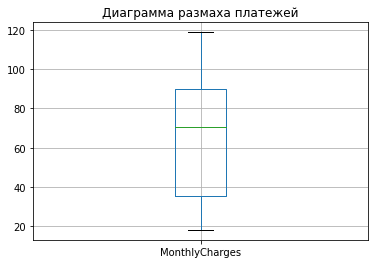

In [35]:
data.boxplot(['MonthlyCharges'])
plt.title('Диаграмма размаха платежей');

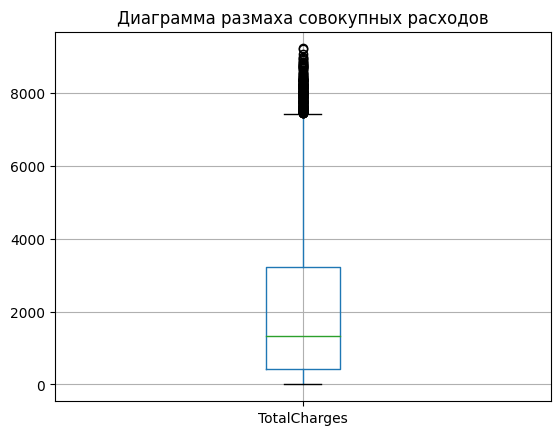

In [36]:
data.boxplot(['TotalCharges'])
plt.title('Диаграмма размаха совокупных расходов');

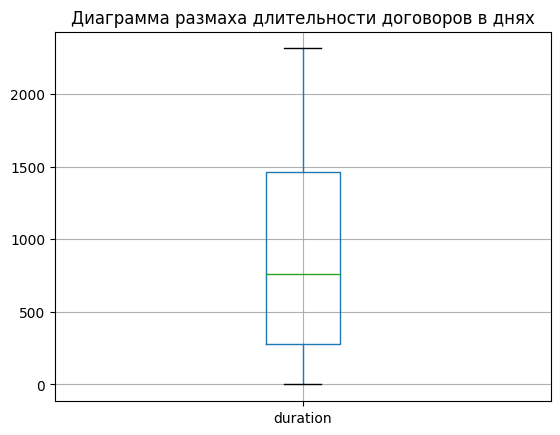

In [37]:
data.boxplot(['duration'])
plt.title('Диаграмма размаха длительности договоров в днях');

По диаграммам размаха видно выбросы в верхней границе признака TotalCharges, однако они находятся в пределах разумных значений, поэтому не требуют удаления.

Посмотрим распределение клиентов по категориальным признакам. Разобьем графики на два - по клиентам, которые остались, и по клиентам, которые ушли.

**1. Распределение клиентов по типу оплаты (Type)**

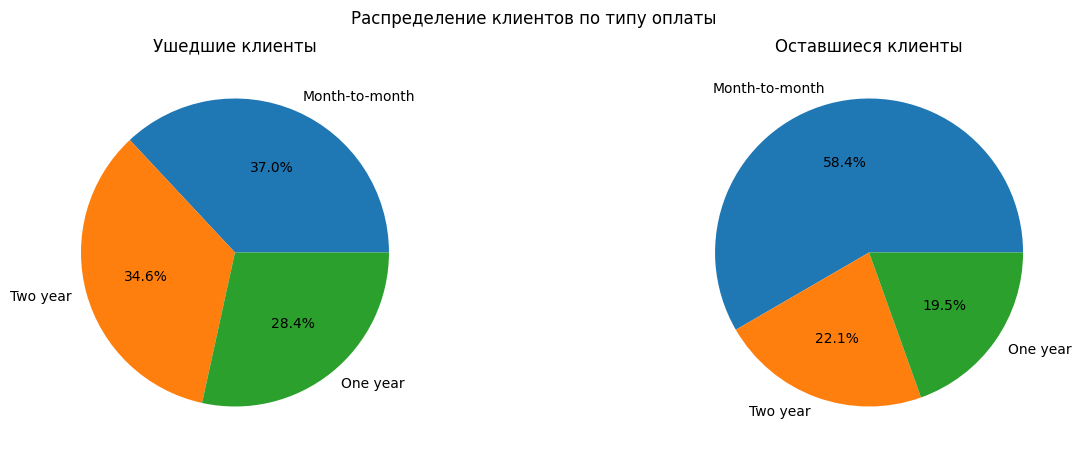

In [38]:
left = data[data['target'] == 1]['Type'].value_counts()
stayed = data[data['target'] == 0]['Type'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по типу оплаты')

plt.show()

В обеих группах распределение идет в одинаковом порядке по возрастанию - оплата за год, оплата за два года и помесячная оплата. При этом среди ушедших клиентов большая часть тех, кто платит за год или за два. А среди оставшихся больше тех, кто платит ежемесячно.

**2. Распределение клиентов по типу расчетного листа (PaperlessBilling)**

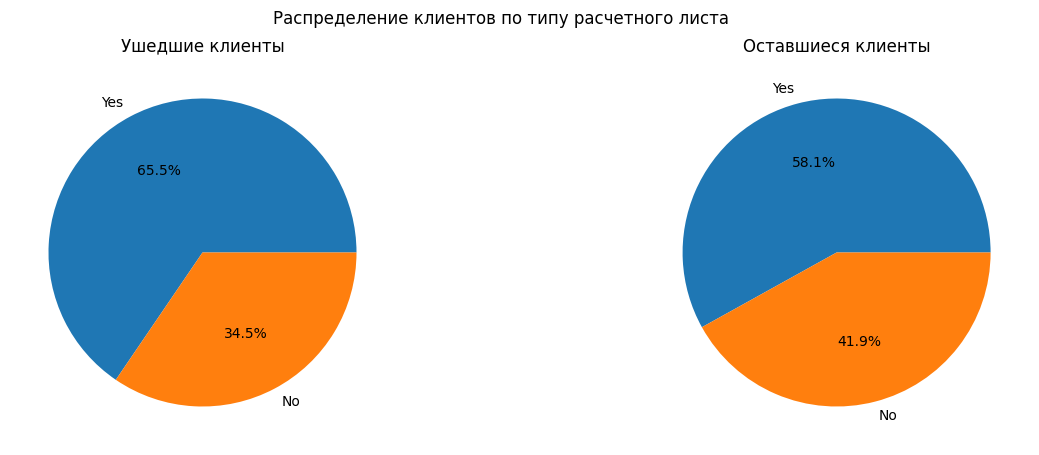

In [39]:
left = data[data['target'] == 1]['PaperlessBilling'].value_counts()
stayed = data[data['target'] == 0]['PaperlessBilling'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по типу расчетного листа')

plt.show()

Распределение примерно одинаковое - расчетный лист в электронном виде получают около 60-65% клиентов.

**3. Распределение клиентов по типу платежа (PaymentMethod)**

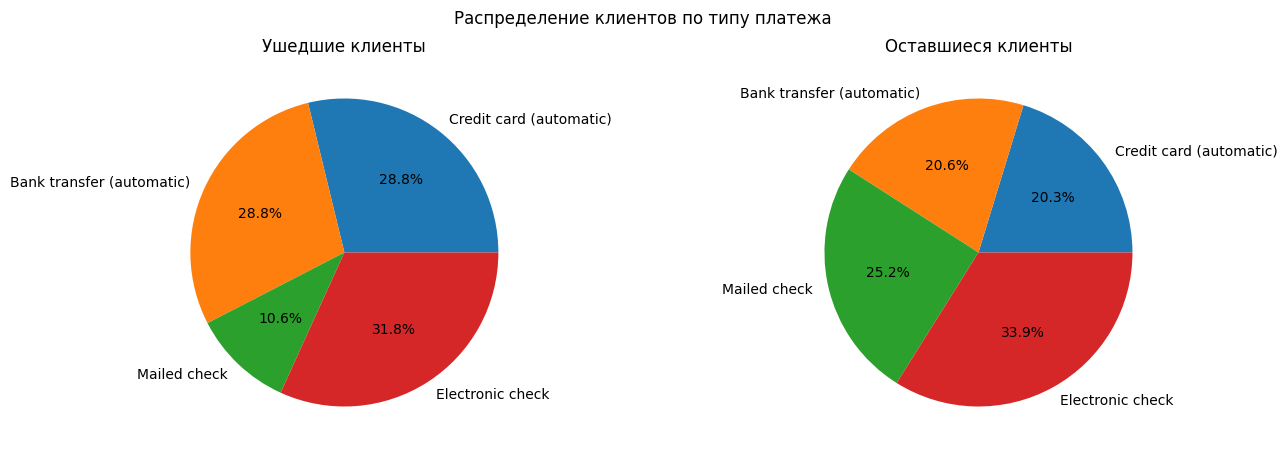

In [40]:
left = data[data['target'] == 1]['PaymentMethod'].value_counts()
stayed = data[data['target'] == 0]['PaymentMethod'].value_counts()

payment_order = ['Credit card (automatic)', 'Bank transfer (automatic)', 'Mailed check', 'Electronic check']

left = left.reindex(payment_order)
stayed = stayed.reindex(payment_order)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по типу платежа')

plt.show()

Среди ушедших клиентов примерно на 20% больше тех, у кого был подключен автоматический платеж (10% через банковский перевод и 10% через кредитную карту). А также на 15% меньше тех, у кого был расчет через почту.

**4. Распределение клиентов по полу (gender)**

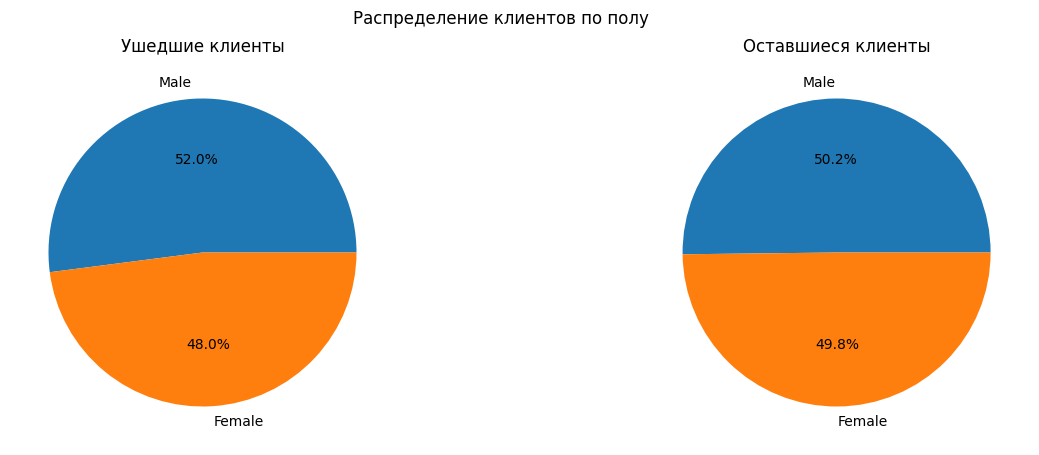

In [41]:
left = data[data['target'] == 1]['gender'].value_counts()
stayed = data[data['target'] == 0]['gender'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по полу')

plt.show()

Распределение примерно одинаковое - женщин и мужчин среди клиентов примерно поровну.

**5. Распределение клиентов по отношению к группе пенсионеров (SeniorCitizen)**

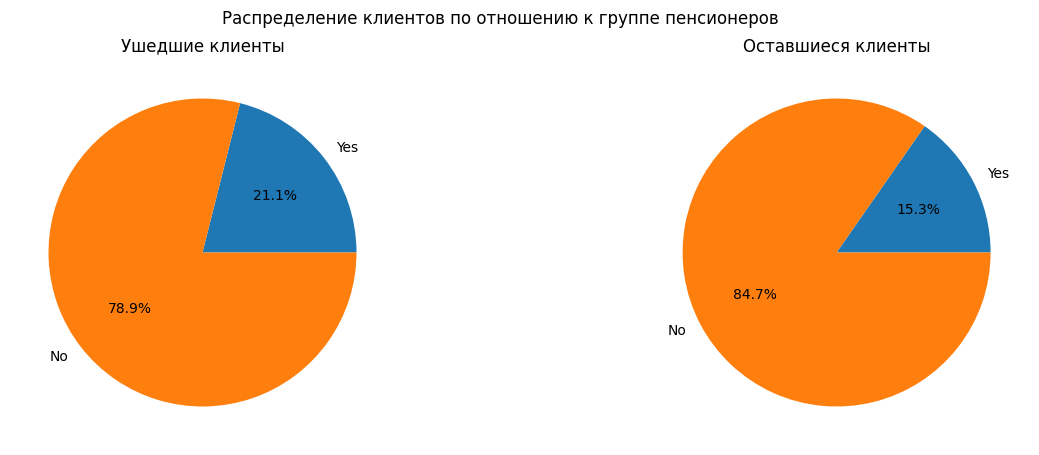

In [42]:
left = data[data['target'] == 1]['SeniorCitizen'].value_counts()
stayed = data[data['target'] == 0]['SeniorCitizen'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по отношению к группе пенсионеров')

plt.show()

Распределение примерно одинаковое - пенсионеров среди клиентов около 15-20%.

**6. Распределение клиентов по наличию супруга (Partner)**

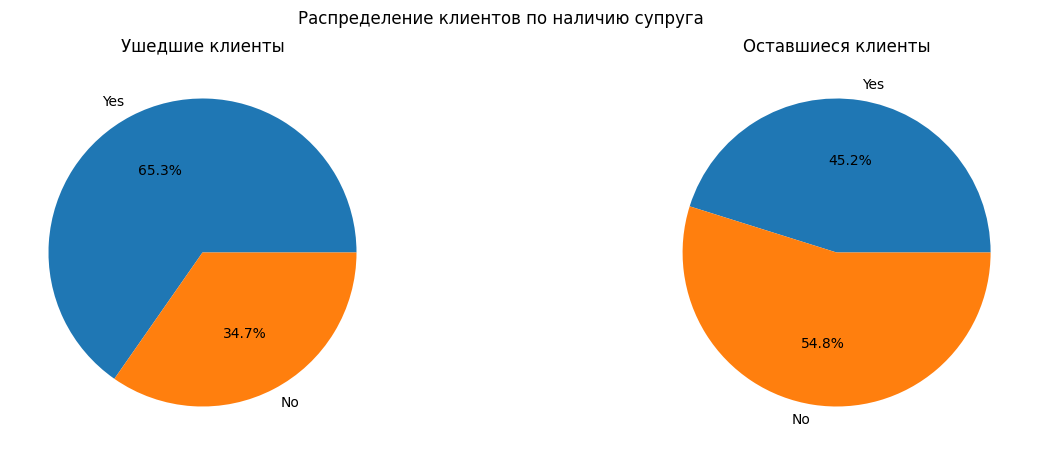

In [43]:
left = data[data['target'] == 1]['Partner'].value_counts()
stayed = data[data['target'] == 0]['Partner'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по наличию супруга')

plt.show()

Клиентов, состоящих в браке, больше среди ушедших клиентов - около 65% против 45% среди оставшихся.

**7. Распределение клиентов по наличию детей (Dependents)**

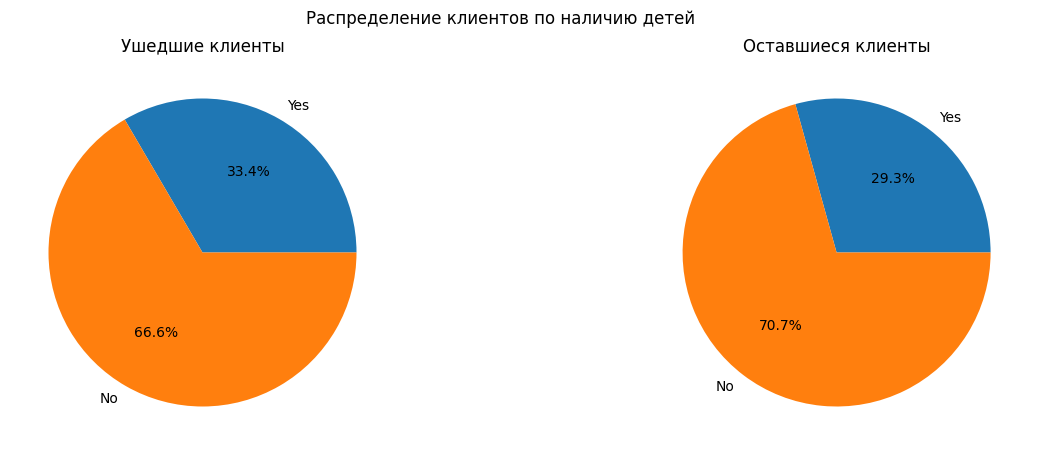

In [44]:
left = data[data['target'] == 1]['Dependents'].value_counts()
stayed = data[data['target'] == 0]['Dependents'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по наличию детей')

plt.show()

Распределение примерно одинаковое - клиентов с детьми около 30%.

**8. Распределение клиентов по типу подключения Интернета (InternetService)**

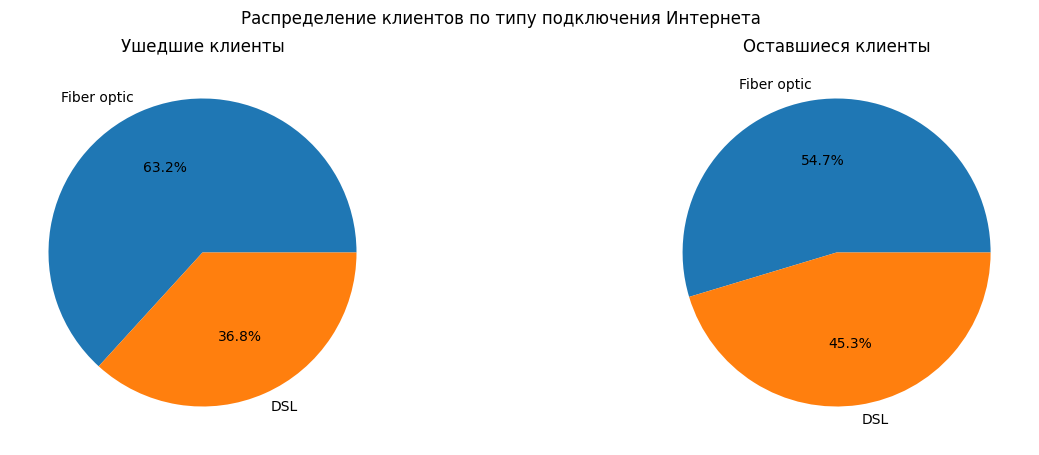

In [45]:
# Фильтруем данные, исключая значения 'Not_user'
left = data[(data['target'] == 1) & (data['InternetService'] != 'Not user')]['InternetService'].value_counts()
stayed = data[(data['target'] == 0) & (data['InternetService'] != 'Not user')]['InternetService'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по типу подключения Интернета')

plt.show()

Среди ушедщих клиентов чуть больше тех, кто подключен через оптоволоконный кабель - 63% против 54% среди оставшихся.

**9. Распределение клиентов по наличию опции блокировка опасных сайтов (OnlineSecurity)**

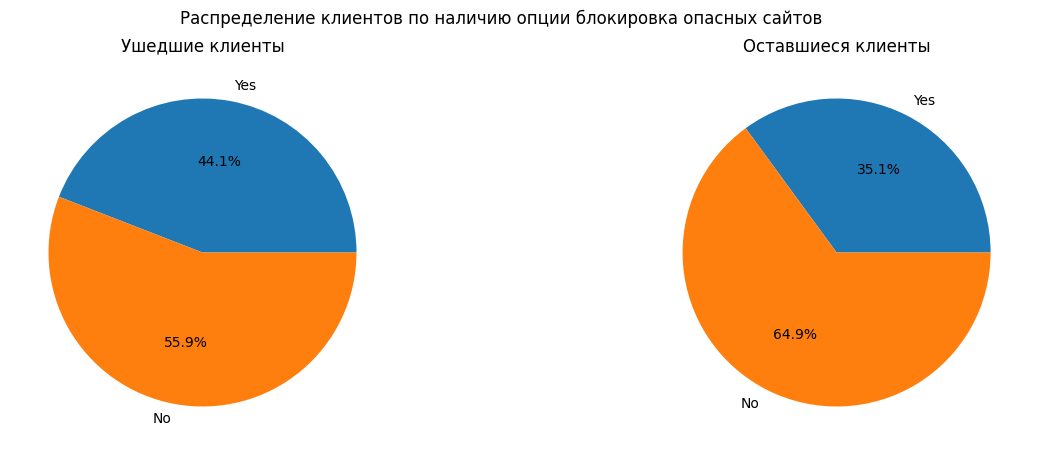

In [46]:
left = data[(data['target'] == 1) & (data['OnlineSecurity'] != 'Not user')]['OnlineSecurity'].value_counts()
stayed = data[(data['target'] == 0) & (data['OnlineSecurity'] != 'Not user')]['OnlineSecurity'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по наличию опции блокировка опасных сайтов')

plt.show()

Среди ушедщих клиентов чуть больше тех, у кого есть блокировка опасных сайтов - 44% против 35% среди оставшихся.

**10. Распределение клиентов по наличию опции резевного копирования (OnlineBackup)**

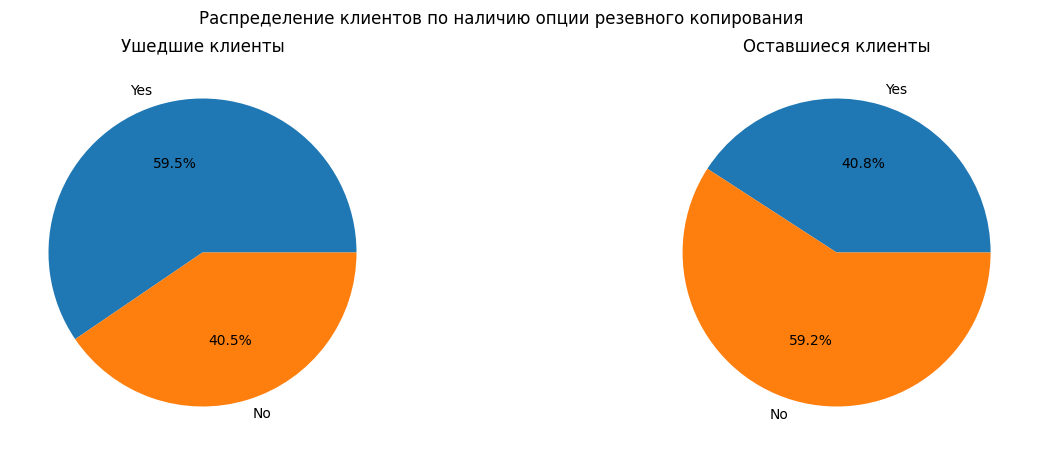

In [47]:
left = data[(data['target'] == 1) & (data['OnlineBackup'] != 'Not user')]['OnlineBackup'].value_counts()
stayed = data[(data['target'] == 0) & (data['OnlineBackup'] != 'Not user')]['OnlineBackup'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по наличию опции резевного копирования')

plt.show()

Среди ушедщих клиентов больше тех, у кого есть резервное копирование - 59% против 40% среди оставшихся.

**11. Распределение клиентов по наличию опции антивирус (DeviceProtection)**

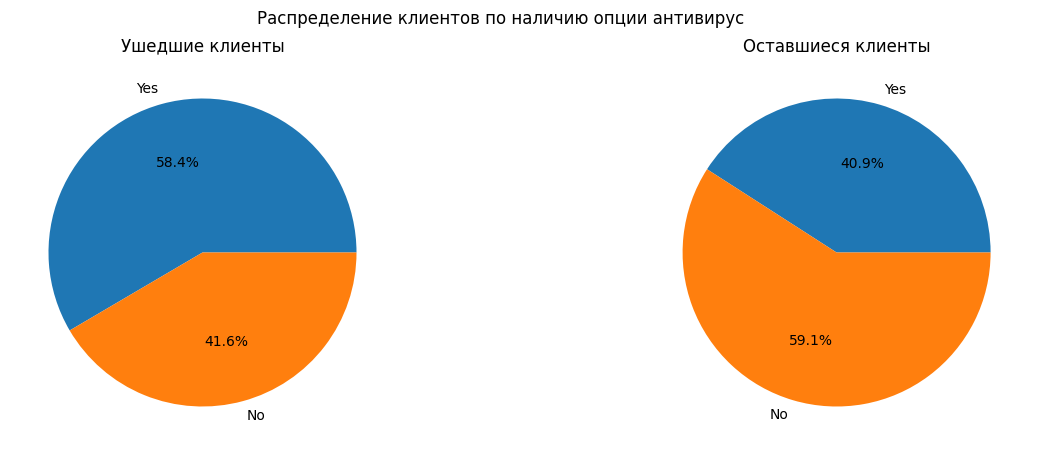

In [48]:
left = data[(data['target'] == 1) & (data['DeviceProtection'] != 'Not user')]['DeviceProtection'].value_counts()
stayed = data[(data['target'] == 0) & (data['DeviceProtection'] != 'Not user')]['DeviceProtection'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по наличию опции антивирус')

plt.show()

Среди ушедщих клиентов больше тех, у кого есть антивирус - 58% против 40% среди оставшихся.

**12. Распределение клиентов по наличию опции линии поддержки (TechSupport)**

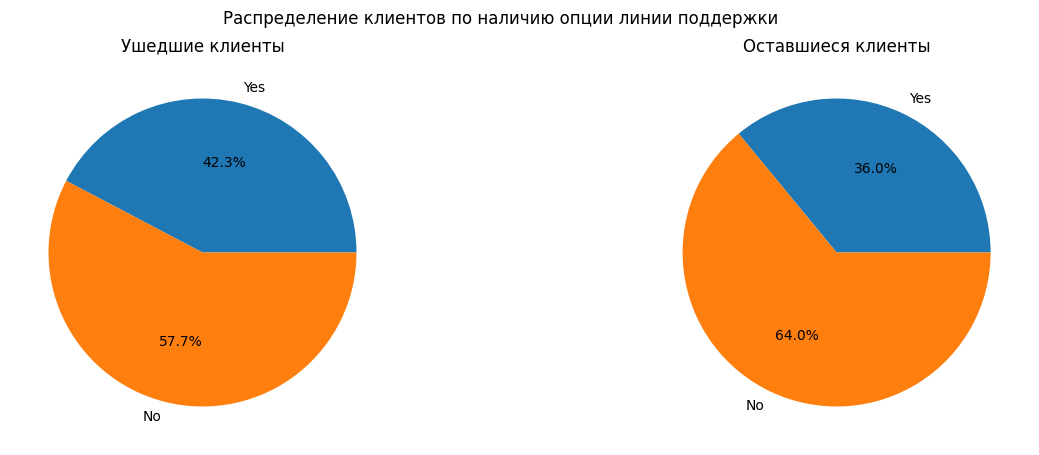

In [49]:
left = data[(data['target'] == 1) & (data['TechSupport'] != 'Not user')]['TechSupport'].value_counts()
stayed = data[(data['target'] == 0) & (data['TechSupport'] != 'Not user')]['TechSupport'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по наличию опции линии поддержки')

plt.show()

Среди ушедщих клиентов чуть больше тех, у кого есть линия поддержки - 42% против 36% среди оставшихся.

**13. Распределение клиентов по наличию опции стриминговое телевидение (StreamingTV)**

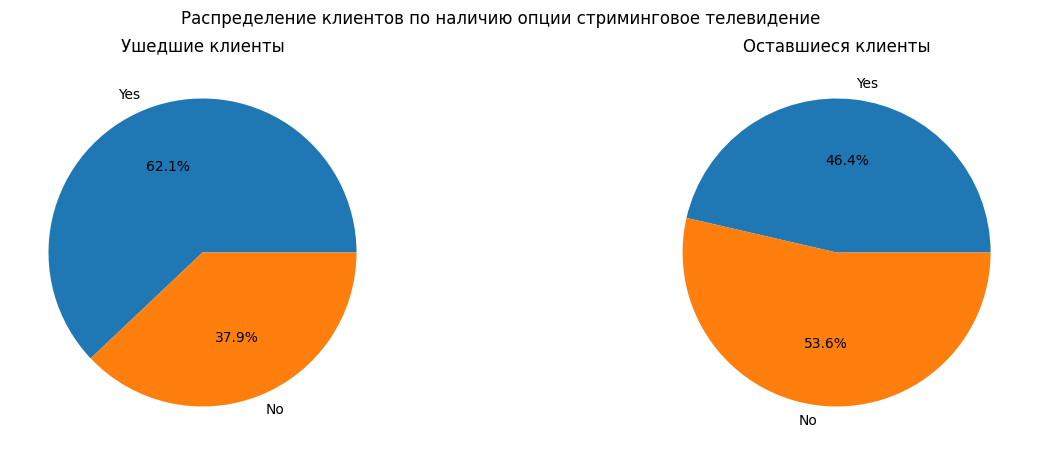

In [50]:
left = data[(data['target'] == 1) & (data['StreamingTV'] != 'Not user')]['StreamingTV'].value_counts()
stayed = data[(data['target'] == 0) & (data['StreamingTV'] != 'Not user')]['StreamingTV'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по наличию опции стриминговое телевидение')

plt.show()

Среди ушедщих клиентов больше тех, у кого есть стриминговое телевидение - 62% против 46% среди оставшихся.

**14. Распределение клиентов по наличию опции каталог фильмов (StreamingMovies)**

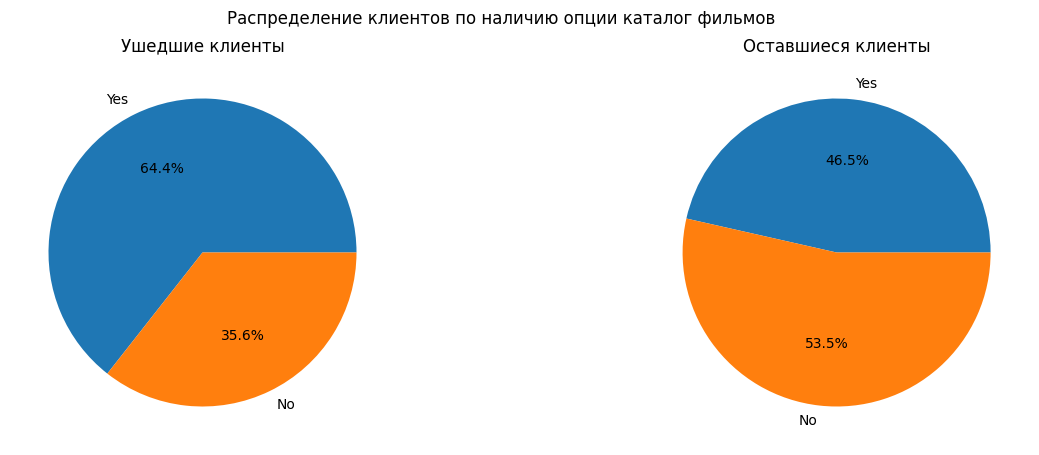

In [51]:
left = data[(data['target'] == 1) & (data['StreamingMovies'] != 'Not user')]['StreamingMovies'].value_counts()
stayed = data[(data['target'] == 0) & (data['StreamingMovies'] != 'Not user')]['StreamingMovies'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов по наличию опции каталог фильмов')

plt.show()

Среди ушедщих клиентов больше тех, у кого есть каталог фильмов - 64% против 46% среди оставшихся.

**15. Распределение клиентов телефонии по наличию опции нескольких линий (MultipleLines)**

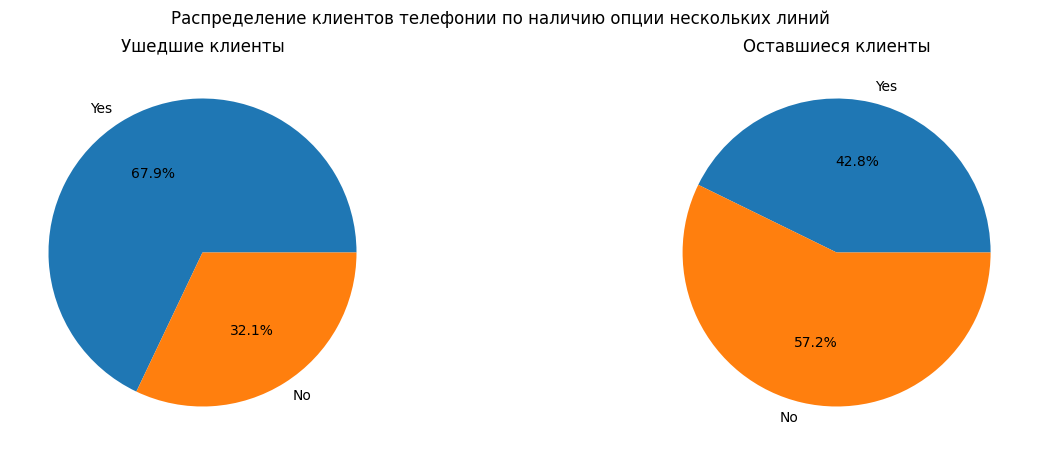

In [52]:
left = data[(data['target'] == 1) & (data['MultipleLines'] != 'Not user')]['MultipleLines'].value_counts()
stayed = data[(data['target'] == 0) & (data['MultipleLines'] != 'Not user')]['MultipleLines'].value_counts()

left = left.reindex(['Yes', 'No'])
stayed = stayed.reindex(['Yes', 'No'])

colors = ['#2E8B57', '#FF6B6B']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.pie(left, labels=left.index, autopct='%1.1f%%')
ax1.set_title('Ушедшие клиенты')

ax2.pie(stayed, labels=stayed.index, autopct='%1.1f%%')
ax2.set_title('Оставшиеся клиенты')

plt.suptitle('Распределение клиентов телефонии по наличию опции нескольких линий')

plt.show()

Среди ушедших клиентов телефонии больше тех, у кого подключено несколько линий - 67% против 42% среди оставшихся.

Таким образом, можно сделать выводы по примерным портретам обеих групп.

Ушедший пользователь:
- чаще платит за год или два;
- чаще имеет подлюченный автоматический платеж;
- чаще имеет супруга;
- имеет большее кол-во подлюченных услуг.

Оставшийся пользователь:
- чаще платит помесячно;
- чаще платит через почту;
- имеет меньшее кол-во подлюченных услуг.

### Корреляционный анализ

Сначала удалим столбец с идентификаторами пользователей - на целевой признак он никак не влияет и в дальнейшем нам уже не понадобится.

In [53]:
data = data.drop('customerID', axis=1)
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,Not user
1,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,Not user
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No


Используем библиотеку phik для подсчёта корреляции между признаками разных типов данных. Визуализируем матрицу корреляции.

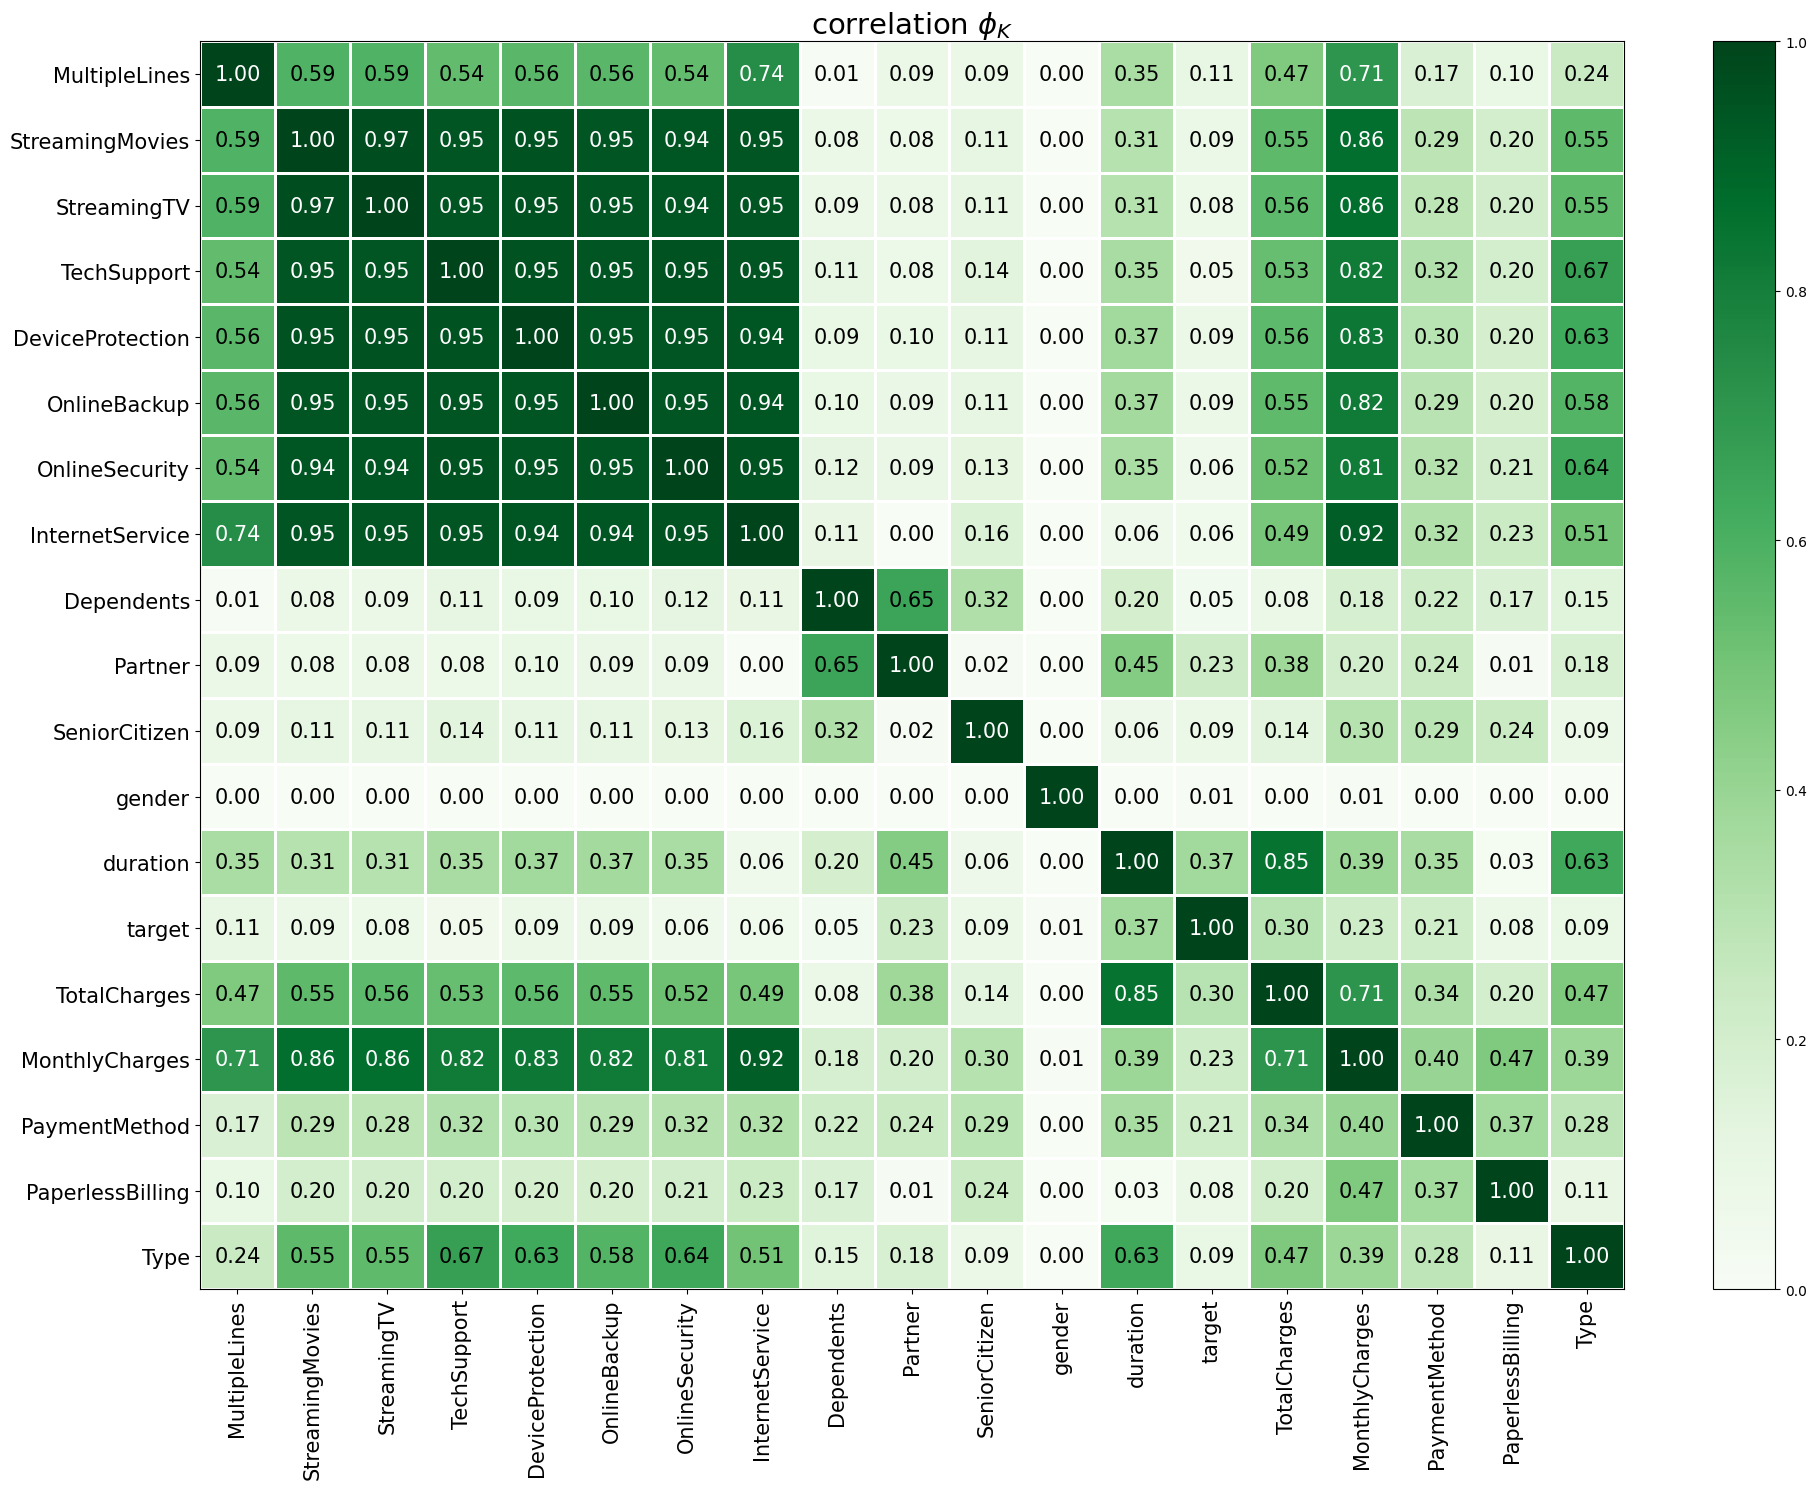

In [54]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'duration']

phik_overview = data.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Между всеми подключенными услугами в рамках интернета есть мультиколлениарность, поэтому заменим их на один новый признак - кол-во подключенных интернет услуг.

In [55]:
data['TotalServices'] = 0

columns_to_count = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies']

for column in columns_to_count:
    data['TotalServices'] += (data[column] == 'Yes').astype(int)
    
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,TotalServices
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,No,Yes,No,No,No,No,Not user,1
1,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,Yes,No,Yes,No,No,No,No,2
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,Yes,Yes,No,No,No,No,No,2
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Yes,No,Yes,Yes,No,No,Not user,3
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,No,No,No,No,No,No,0


Вывод корректен, уберем столбцы с интернет услугами.

In [56]:
data = data.drop(['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                   'TechSupport', 'StreamingTV', 'StreamingMovies'], axis=1)
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,duration,gender,SeniorCitizen,Partner,Dependents,InternetService,MultipleLines,TotalServices
0,Month-to-month,Yes,Electronic check,29.85,31.04,0,31,Female,No,Yes,No,DSL,Not user,1
1,One year,No,Mailed check,56.95,2071.84,0,1036,Male,No,No,No,DSL,No,2
2,Month-to-month,Yes,Mailed check,53.85,226.17,0,123,Male,No,No,No,DSL,No,2
3,One year,No,Bank transfer (automatic),42.30,1960.60,0,1371,Male,No,No,No,DSL,Not user,3
4,Month-to-month,Yes,Electronic check,70.70,353.50,0,153,Female,No,No,No,Fiber optic,No,0


Снова построим матрицу корреляций.

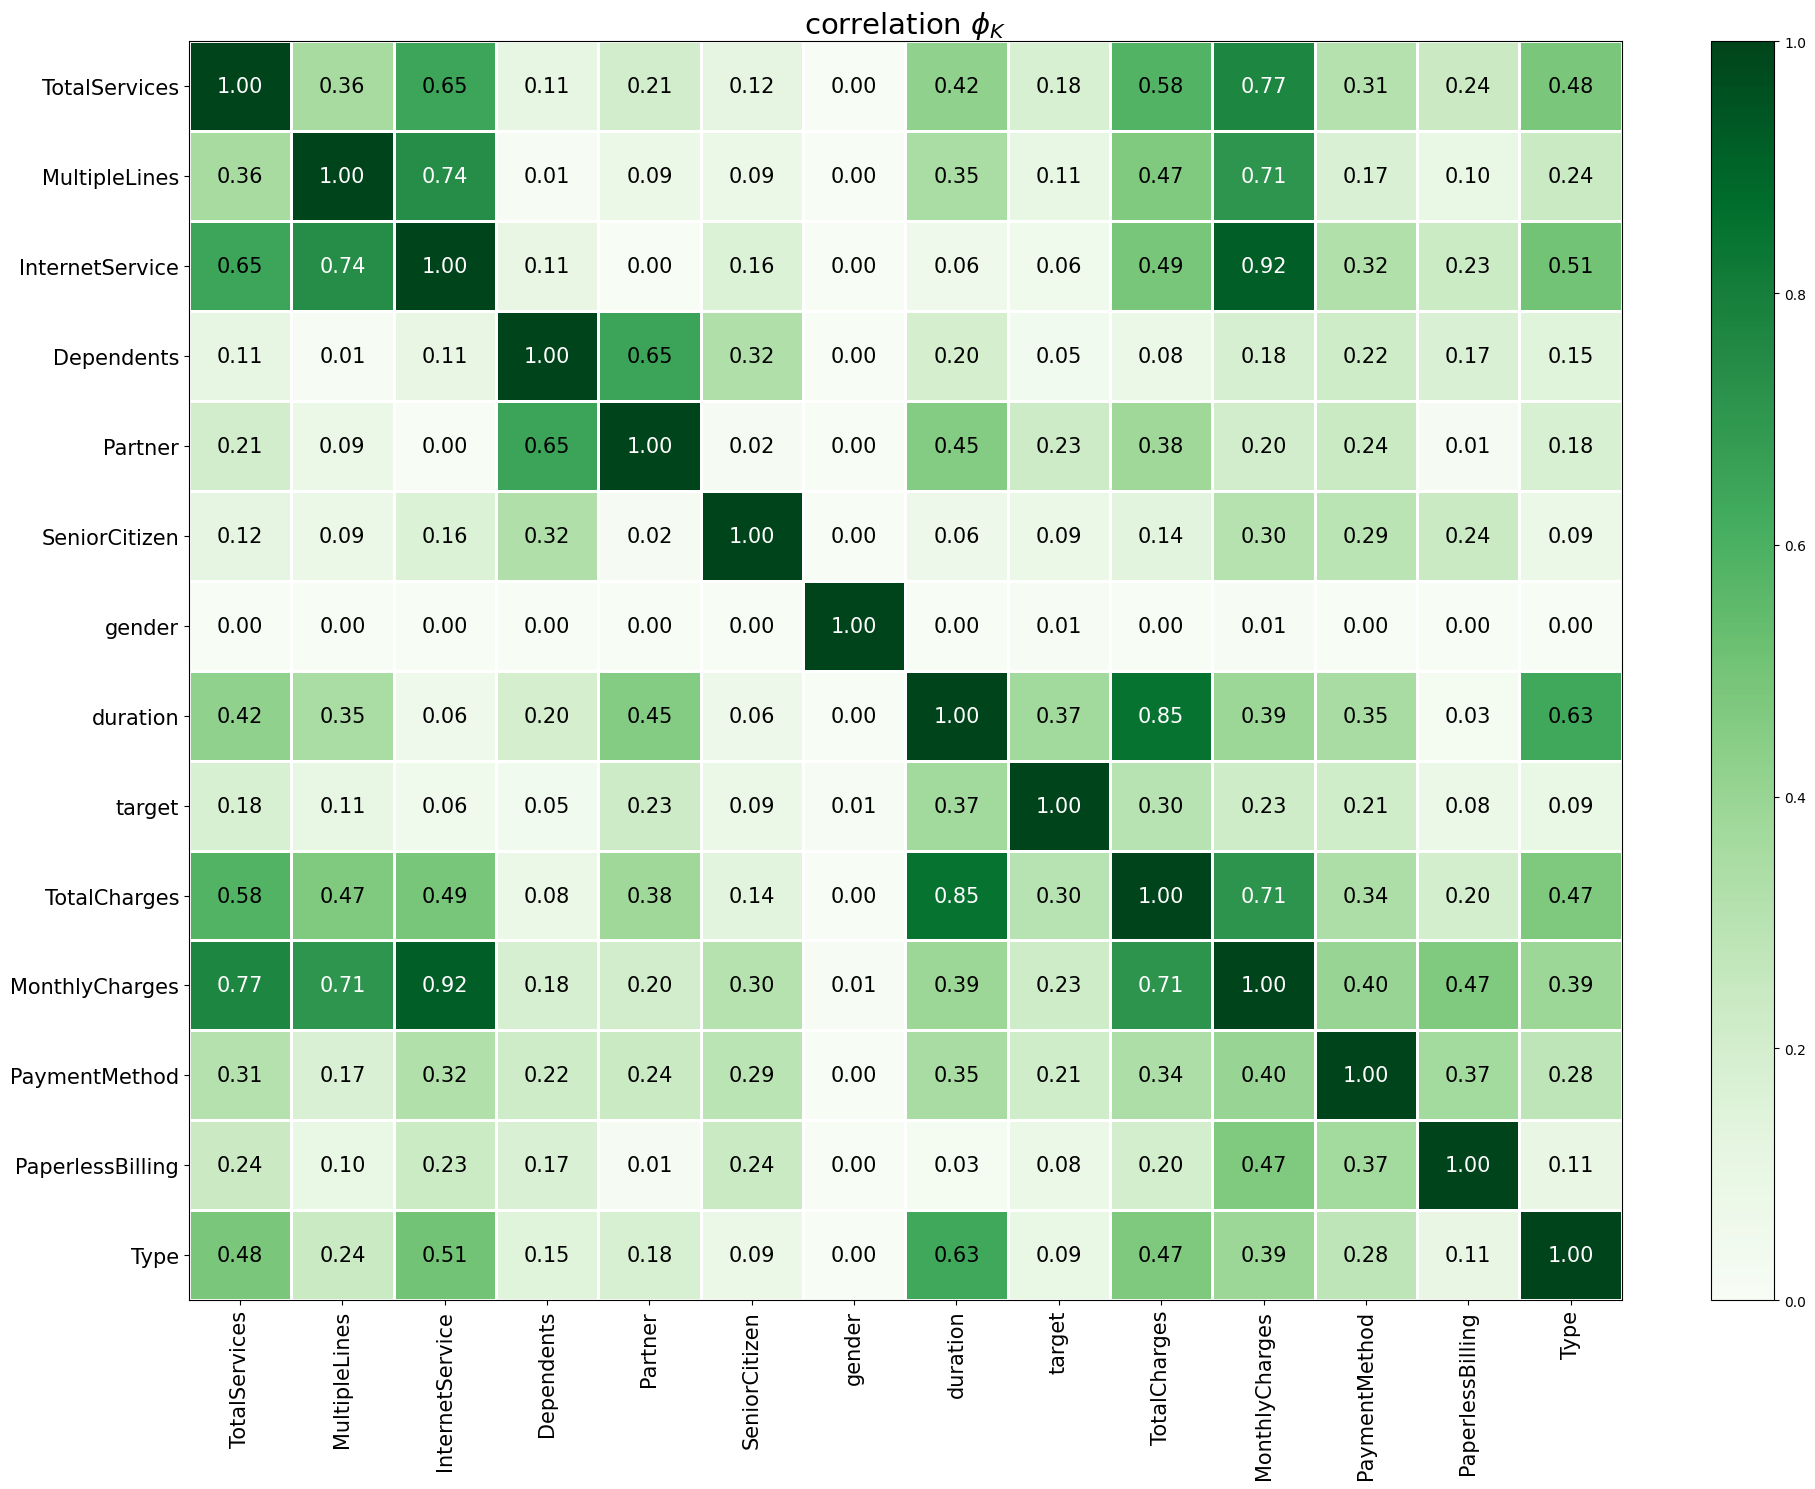

In [57]:
interval_cols = ['MonthlyCharges', 'TotalCharges', 'duration', 'TotalServices']

phik_overview = data.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

Теперь мультиколлинеарность между признаками отсутствует (нет коэффициентов выше 0,95).

Значений коэффициентов корреляции с целевым признаком выше 0.9 тоже нет, значит утечки данных не будет.


Проанализируем коэффициенты корреляции признаков с таргетом.

- Слабая связь (меньше 0.3): Type, PaperlessBilling, PaymentMethod, MonthlyCharges, gender, SeniorCitizen, Partner, Dependents, InternetService, TotalServices.

- Умеренная связь (0.3–0.5): TotalCharges, duration.

- Сильная связь (больше 0.5): -.

### Выводы

**Исследовательский анализ** показал, что:
- платежи клиентов составляют 18-118 д.е. В среднем клиент ежемесячно тратит около 64 д.е.
- общие расходы клиентов находятся в промежутке от 0 до 9221 д.е. Среднее значение - 2115 д.е.
- длительность договора в днях варьируется от 0 до 2314 дней. В среднем длительность договора равна 898 дню.

По диаграммам размаха видно выбросы в верхней границе признака TotalCharges, однако они находятся в пределах разумных значений, поэтому не требуют удаления.

Также в рамках исследовательского анализа было изучено распределение клиентов по категориальным признакам. Анализ сразу включал сравнение по двум группам - по клиентам, которые остались, и по клиентам, которые ушли.

1. Тип оплаты - в обеих группах распределение идет в одинаковом порядке по возрастанию - оплата за год, оплата за два года и помесячная оплата. При этом среди ушедших клиентов большая часть тех, кто платит за год или за два. А среди оставшихся больше тех, кто платит ежемесячно.
2. Тип расчетного листа - распределение примерно одинаковое - расчетный лист в электронном виде получают около 60-65% клиентов.
3. Тип платежа - среди ушедших клиентов примерно на 20% больше тех, у кого был подключен автоматический платеж (10% через банковский перевод и 10% через кредитную карту). А также на 15% меньше тех, у кого был расчет через почту.
4. Пол - распределение примерно одинаковое - женщин и мужчин среди клиентов примерно поровну.
5. Пенсионеры - распределение примерно одинаковое - пенсионеров среди клиентов около 15-20%.
6. Наличие супруга - клиентов, состоящих в браке, больше среди ушедших клиентов - около 65% против 45% среди оставшихся.
7. Наличие детей - распределение примерно одинаковое - клиентов с детьми около 30%.
8. Тип подключения интернета - среди ушедщих клиентов чуть больше тех, кто подключен через оптоволоконный кабель - 63% против 54% среди оставшихся.
9. Блокировка опасных сайтов - среди ушедщих клиентов чуть больше тех, у кого есть блокировка опасных сайтов - 44% против 35% среди оставшихся.
10. Резервное копирование - среди ушедщих клиентов больше тех, у кого есть резервное копирование - 59% против 40% среди оставшихся.
11. Антивирус - среди ушедщих клиентов больше тех, у кого есть антивирус - 58% против 40% среди оставшихся.
12. Линия поддержки - среди ушедщих клиентов чуть больше тех, у кого есть линия поддержки - 42% против 36% среди оставшихся.
13. Стриминговое телевидение - среди ушедщих клиентов больше тех, у кого есть стриминговое телевидение - 62% против 46% среди оставшихся.
14. Каталог фильмов - среди ушедщих клиентов больше тех, у кого есть каталог фильмов - 64% против 46% среди оставшихся.
15. Несколько линий телефонии - среди ушедших клиентов телефонии больше тех, у кого подключено несколько линий - 67% против 42% среди оставшихся.

Таким образом, можно сделать выводы по примерным портретам обеих групп.

Ушедший пользователь:
- чаще платит за год или два;
- чаще имеет подлюченный автоматический платеж;
- чаще имеет супруга;
- имеет большее кол-во подлюченных услуг.

Оставшийся пользователь:
- чаще платит помесячно;
- чаще платит через почту;
- имеет меньшее кол-во подлюченных услуг.

Также был проведен **корреляционный анализ**, который показал, что между всеми подключенными услугами в рамках интернета есть мультиколлениарность, поэтому они были заменены на один новый признак - кол-во подключенных интернет услуг.

Повторный анализ показал, что мультиколлинеарность была устранены (нет коэффициентов выше 0,95). Значений коэффициентов корреляции с целевым признаком выше 0.9 тоже нет, значит утечки данных не будет.

Коэффициенты корреляции признаков с таргетом:

- Слабая связь (меньше 0.3): Type, PaperlessBilling, PaymentMethod, MonthlyCharges, gender, SeniorCitizen, Partner, Dependents, InternetService, TotalServices.
- Умеренная связь (0.3–0.5): TotalCharges, duration.
- Сильная связь (больше 0.5): -.

## Подготовка данных

### Подготовка данных

Разделим данные на тренировочные и тестовые, а также вынесем целевой признак.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('target', axis=1),
    data['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['target']
)

Подготовим списки категориальных и количественных признаков для кодирования и масштабирования.

In [59]:
cat_col_names = ['Type', 'PaperlessBilling', 'PaymentMethod', 'gender',
                 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'MultipleLines']
num_col_names = ['MonthlyCharges', 'TotalCharges', 'duration', 'TotalServices']

Кодируем категориальные признаки с помощью OneHotEncoder.

In [60]:
# создадим переменную с экземпляром класса OneHotEncoder()
encoder = OneHotEncoder(drop='first', sparse=False)

# обучим и трансформируем категориальные признаки из тренировочной выборки 
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

# выполним преобразование категориальных признаков в тестовой выборке
X_test_ohe = encoder.transform(X_test[cat_col_names])

# получим от кодировщика список новых столбцов и сохраним в новой переменной 
encoder_col_names = encoder.get_feature_names()

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Масштабируем количественные признаки с помощью StandardScaler.

In [61]:
# создадим переменную с экземпляром класса StandardScaler()
scaler = StandardScaler()

# обучим и трансформируем количественные признаки из тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[num_col_names])

# выполним преобразование количественных признаков в тестовой выборке и выведем одну строку данных, чтобы убедиться, что результат ожидаемый
X_test_scaled = scaler.transform(X_test[num_col_names])
X_test_scaled[1]

array([ 0.7232467 , -0.3502691 , -0.60722178, -0.55982164])

Объединим подготовленные количественные и категориальные данные.

In [62]:
# создадим тренировочный и тестовый датафреймы из закодированных и отмасштабированных данных
# для данных OHE названия столбцов укажем из переменной encoder_col_names

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

# объединим все преобразованные данные в тренировочный и тестовый датафреймы
# сбросим индексы в датафрейме с числовыми индексами, чтобы избежать ошибок

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

Данные готовы к обучению.

### Выводы

Данные были разделены на тренировочные и тестовые, целевой признак - вынесен отдельно.

Категориальные признаки были закодированы с помощью OneHotEncoder. Количественные признаки были масштабированы с помощью StandardScaler.

Подготовленные количественные и категориальные данные были объединенны - данные готовы к обучению.

## Обучение моделей машинного обучения

Построим модель, которая будет предсказывать уйдет ли пользователь оператора или нет.

Попробуем обучить два вида моделей - RandomForestClassifier и CatBoostClassifier.

Качество будем измерять по roc-auc на кросс-валидации с подбором 2-3 гиперпараметров через RandomizedSearchCV.

### RandomForestClassifier

In [67]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 7, 9, 13, 15],
    'min_samples_split': [3, 5, 10]
}

rf_search = RandomizedSearchCV(
    rf_model,
    rf_params,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("\nЛучшие параметры Random Forest:", rf_search.best_params_)
print("Лучший ROC-AUC Random Forest:", rf_search.best_score_)


Лучшие параметры Random Forest: {'n_estimators': 300, 'min_samples_split': 3, 'max_depth': 9}
Лучший ROC-AUC Random Forest: 0.8302307324539818


Метрика качества ниже требуемого 0.85.

При этом видно, что параметр модели min_samples_split уперcя в крайнее значение при подборе. Попробуем расширить/сместить диапазон.

In [68]:
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [5, 7, 9, 13, 15],
    'min_samples_split': [2, 3, 5, 10, 11, 12, 13]
}

rf_search = RandomizedSearchCV(
    rf_model,
    rf_params,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print("\nЛучшие параметры Random Forest:", rf_search.best_params_)
print("Лучший ROC-AUC Random Forest:", rf_search.best_score_)


Лучшие параметры Random Forest: {'n_estimators': 500, 'min_samples_split': 11, 'max_depth': 9}
Лучший ROC-AUC Random Forest: 0.8294919832475577


Качество модели поднять не удалось - оно все равно ниже требуемого.

### CatBoostClassifier

In [69]:
cb_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

cb_params = {
    'iterations': [100, 200, 300],
    'depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2]
}

cb_search = RandomizedSearchCV(
    cb_model,
    cb_params,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

cb_search.fit(X_train, y_train)

print("\nЛучшие параметры CatBoost:", cb_search.best_params_)
print("Лучший ROC-AUC CatBoost:", cb_search.best_score_)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.


Лучшие параметры CatBoost: {'learning_rate': 0.2, 'iterations': 200, 'depth': 4}
Лучший ROC-AUC CatBoost: 0.8917310971588955


Метрика качества выше требуемого.

При этом параметры модели learning_rate и depth - уперлись в крайние значения при подборе. Попробуем их расширить/сместить.

In [70]:
cb_model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

cb_params = {
    'iterations': [100, 200, 300, 400],
    'depth': [2, 3, 4, 5],
    'learning_rate': [0.2, 0.3, 0.4, 0.5]
}

cb_search = RandomizedSearchCV(
    cb_model,
    cb_params,
    cv=3,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

cb_search.fit(X_train, y_train)

print("\nЛучшие параметры CatBoost:", cb_search.best_params_)
print("Лучший ROC-AUC CatBoost:", cb_search.best_score_)


Лучшие параметры CatBoost: {'learning_rate': 0.3, 'iterations': 300, 'depth': 4}
Лучший ROC-AUC CatBoost: 0.9069891533959525


Удалось улучшить результат. Эту модель берем в дальнейшую работу.

In [71]:
best_cb = cb_search.best_estimator_

### Выводы

Целью обучения было получить модель, которая будет предсказывать уйдет ли пользователь оператора или нет.

Было обучено два вида моделей - RandomForestClassifier и CatBoostClassifier.

Качество измерялось по roc-auc на кросс-валидации с подбором 2-3 гиперпараметров через RandomizedSearchCV.

Первая модель RandomForestClassifier показала качество ниже требуемого - 0.8302. При этом параметр модели min_samples_split уперся в крайнее значение при подборе. После расширения диапазона параметра качество модели поднять не удалось - оно все равно ниже требуемого (0.8294).

Вторая модель CatBoostClassifier показала качество выше требуемого - 0.8917. При этом параметры модели learning_rate и depth - уперлись в крайние значения при подборе. После расширения диапазона параметров качество модели удалось поднять до 0.9069.

## Выбор лучшей модели

### Качество на тесте

В результате обучения моделей лучшей оказалась модель CatBoostClassifier с гиперпараметрами 'learning_rate': 0.3, 'iterations': 300, 'depth': 4.

Ее метрика качества roc-auc на тренировочных данных с кросс-валидацией составила 0,9069.

Посмотрим результат метрики roc-auc, а также accuracy (для интерпретируемости) на тестовых данных.

In [72]:
y_pred_proba = best_cb.predict_proba(X_test)[:, 1]
y_pred = best_cb.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print("Результаты на тестовых данных:")
print(f"ROC-AUC: {roc_auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Результаты на тестовых данных:
ROC-AUC: 0.9228
Accuracy: 0.9358


Результат на тестовых данных выше требуемого.

Значение accuracy говорит о том, что модель правильно идентифицирует 93% случаев ухода/не ухода.

### Матрица ошибок

Построим матрицу ошибок, чтобы проанализировать долю ошибочных прогнозов у каждого класса.

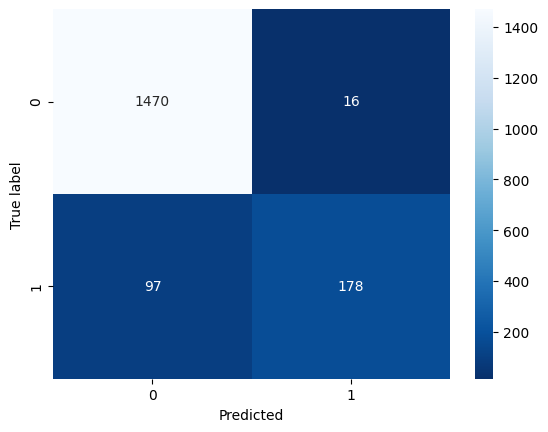

In [73]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

Матрица ошибок показывает, что модель 16 раз ошибочно предсказывает, что клиент уйдет (ошибка 1 рода), и 97 раз ошибочно предсказывает, что клиент останется (ошибка 2 рода).

Рассчитаем метрики precision и recall.

In [74]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('precision: ',round(precision,2))
print('recall: ',round(recall ,2))

precision:  0.92
recall:  0.65


Precision - Доля правильно предсказанных уходов клиентов среди всех предсказанных уходов составляет 92%. То есть только в 8% предсказаний модель указывает, что клиент уйдет, хотя это не так. На эту метрику следует ориентироваться в дальнейшем, если для оператора важнее снизить кол-во ошибок среди клиентов, которым спрогнозирован уход (например, чтобы снизить траты на дополнительную коммуникацию с такими клиентами).

Recall - Доля предсказанных уходов клиентов среди реальных уходов составляет 65%. То есть модель помогает предугадать уход клиентов в 65% случаев. На эту метрику следует ориентироваться в дальнейшем, если для оператора важнее как можно полнее охватить всех клиентов, которые могут уйти (например, чтобы максимально снизить потери от возможного ухода клиента).

###  ROC-кривая

Рассчитаем значения FPR и TRP и построим график зависимости FPR от TPR.

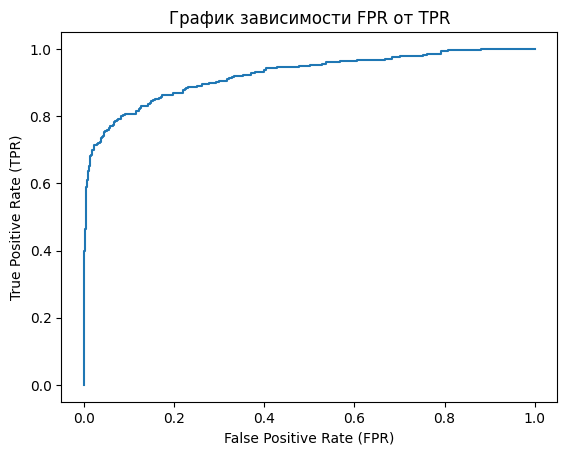

In [75]:
fpr, tpr, threshold = roc_curve(y_test, y_pred_proba, pos_label=1)

plt.plot(fpr, tpr)
plt.title("График зависимости FPR от TPR")
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.show()

Этот график отображает динамику качества классификации при разных порогах. Он показывает зависимость между TPR и FPR — промежуточными метриками, которые оценивают число верно классифицированных объектов класса 1 и неверно классифицированных объектов класса 0. Лучшее качество модели — в точке перелома кривой, так как у идеальной модели метрика TPR стремится к единице, а FPR — к нулю.

На данном этапе график стремится к идеальному виду и показывает отличное качество модели - кривая резко меняет наклон и площадь под кривой покрывает почти весь график.

В дальнейшем можно подобрать порог принадлежности с учетом того, какой род ошибки будет наиболее критичным для оператора, чтобы улучшить качество модели в рамках этой цели.

### Анализ важности признаков

Оценим важность признаков для лучшей модели, построив графики с помощью метода SHAP. Для сокращения времени исполнения передадим случайную выборку из 100 объектов.

Сначала построим столбчатую диаграмму метода SHAP, которая отражает общий вклад признаков в прогнозы модели.

In [76]:
train_sample = X_train.sample(n=100, random_state=RANDOM_STATE)
test_sample = X_test.sample(n=100, random_state=RANDOM_STATE)

explainer = shap.KernelExplainer(best_cb.predict_proba, train_sample)
shap_values = explainer(test_sample)

  0%|          | 0/100 [00:00<?, ?it/s]

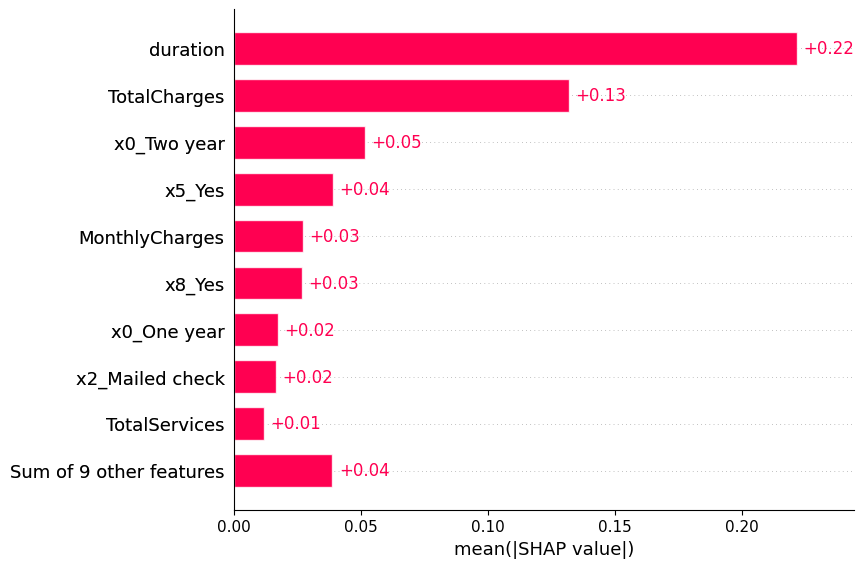

In [77]:
shap.plots.bar(shap_values[:, :, 1])

Визуализируем вклад признаков в каждое предсказание модели.

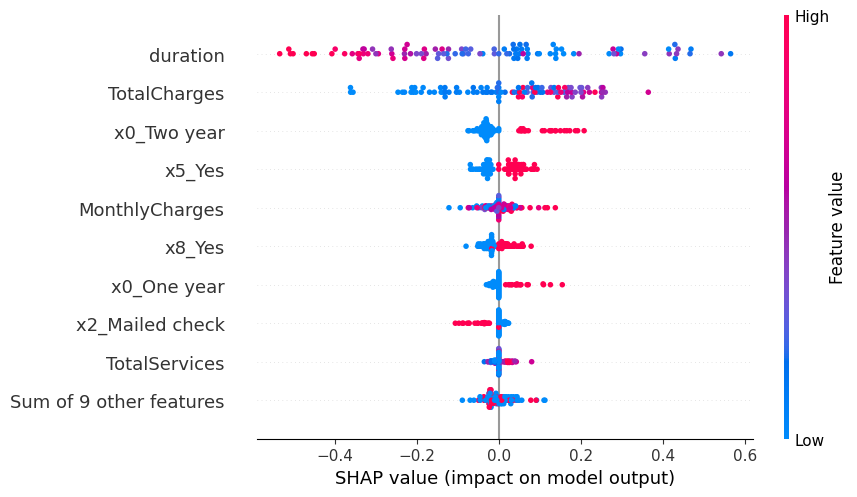

In [78]:
shap.plots.beeswarm(shap_values[:, :, 1])

Графики показывают, что сильнее всего с целевым признаком коррелируют такие признаки, как:
- duration: длительность договора в днях. Если пользователь заключил договор недавно, то вероятность его ухода выше.
- TotalCharges: общие расходы абонента. Чем выше у пользователя общие расходы, тем выше вероятность его ухода.
- значение Two year в рамках признака Type: тип оплаты сразу за два года. Если пользователь платит не ежемесячно, а сразу за два года (или за один - это значение имеет такой же характер влияния, но менее интенсивное), то вероятность его ухода выше.

### Выводы

В результате обучения моделей лучшей оказалась модель CatBoostClassifier с гиперпараметрами 'learning_rate': 0.3, 'iterations': 300, 'depth': 4. Ее метрика качества roc-auc на тренировочных данных с кросс-валидацией составила 0,9069.

Результат на тестовых данных оказался также выше требуемого - 0.9228. Также на тестовых данных был рассчитан accuracy (для интерпретируемости) - он равен 0.9289, то есть модель правильно идентифицирует 93% случаев ухода/не ухода.

Матрица ошибок позволила проанализировать долю ошибочных прогнозов у каждого класса - модель 16 раз ошибочно предсказывает, что клиент уйдет (ошибка 1 рода), и 97 раз ошибочно предсказывает, что клиент останется (ошибка 2 рода).

Также были рассчитаны метрики precision (0.92) и recall (0.65). 

- Precision - Доля правильно предсказанных уходов клиентов среди всех предсказанных уходов составляет 92%. То есть только в 8% предсказаний модель указывает, что клиент уйдет, хотя это не так. На эту метрику следует ориентироваться в дальнейшем, если для оператора важнее снизить кол-во ошибок среди клиентов, которым спрогнозирован уход (например, чтобы снизить траты на дополнительную коммуникацию с такими клиентами).
- Recall - Доля предсказанных уходов клиентов среди реальных уходов составляет 65%. То есть модель помогает предугадать уход клиентов в 65% случаев. На эту метрику следует ориентироваться в дальнейшем, если для оператора важнее как можно полнее охватить всех клиентов, которые могут уйти (например, чтобы максимально снизить потери от возможного ухода клиента).

Для визуализации был построена ROC-кривая - график зависимости FPR от TPR. Этот график отображает динамику качества классификации при разных порогах. Он показывает зависимость между TPR и FPR — промежуточными метриками, которые оценивают число верно классифицированных объектов класса 1 и неверно классифицированных объектов класса 0. Лучшее качество модели — в точке перелома кривой, так как у идеальной модели метрика TPR стремится к единице, а FPR — к нулю.

На данном этапе график ROC-кривой стремится к идеальному виду и показывает отличное качество модели - кривая резко меняет наклон и площадь под кривой покрывает почти весь график. В дальнейшем можно подобрать порог принадлежности с учетом того, какой род ошибки будет наиболее критичным для оператора, чтобы улучшить качество модели в рамках этой цели.

Для оценки важности признаков для лучшей модели были построены графики с помощью метода SHAP. Для сокращения времени исполнения передавалась случайная выборку из 100 объектов.

Столбчатая диаграмма метода SHAP отразила общий вклад признаков в прогнозы модели. Второй график визуализировал вклад признаков в каждое предсказание модели. Графики показали, что сильнее всего с целевым признаком коррелируют такие признаки, как:
- duration: длительность договора в днях. Если пользователь заключил договор недавно, то вероятность его ухода выше.
- TotalCharges: общие расходы абонента. Чем выше у пользователя общие расходы, тем выше вероятность его ухода.
- значение Two year в рамках признака Type: тип оплаты сразу за два года. Если пользователь платит не ежемесячно, а сразу за два года (или за один - это значение имеет такой же характер влияния, но менее интенсивное), то вероятность его ухода выше.

## Общий вывод и рекомендации заказчику

**ОПИСАНИЕ ПРОЕКТА**

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах.

**ЦЕЛЬ ПРОЕКТА**

Обучить на этих данных модель для прогноза оттока клиентов. Она позволит бороться с оттоком путем введения промокодов и специальных условий для таких клиентов.

**ЗАГРУЗКА ДАННЫХ**

Предоставленные данные содержатся в четырех датафреймах:
- contract — информация о договоре;
- personal — персональные данные клиента;
- internet — информация об интернет-услугах;
- phone — информация об услугах телефонии.

Датафрейм **contract** содержит информацию о договоре:
- customerID — идентификатор абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Датафрейм **personal** содержит персональные данные клиента:
- customerID — идентификатор пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Датафрейм **internet** содержит информацию об интернет-услугах:
- customerID — идентификатор пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Датафрейм **phone** содержит информацию об услугах cтационарной телефонной связи:
- customerID — идентификатор пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Во всех файлах столбец customerID содержит код клиента. Информация о договорах актуальна на 1 февраля 2020 года.

Датафрейм **contract** содержит 8 столбцов и 7 043 строки. Пропусков нет, типы данных соответствуют, но не везде. Необходимо будет перевести столбцы BeginDate и EndDate в тип даты, а столбец TotalCharges в тип float64.

Датафрейм **personal** содержит 5 столбцов и 7 043 строки. Пропусков нет, типы данных соответствуют, но не везде. Необходимо будет перевести столбец SeniorCitizen в тип object, так как это категориальный признак.

Датафрейм **internet** содержит 8 столбцов и 5 517 строк. Пропусков нет, типы данных соответствуют.

Датафрейм **phone** содержит 2 столбца и 6 261 строку. Пропусков нет, типы данных соответствуют.

Дубликаты в данных отсутствуют.

Таким образом, предоставлены данные о 7 043 клиентах оператора - кол-во наблюдений в датафреймах о заключенных договорах и персональных данных совпадают. При этом услугами интернета пользуются 5 517 клиентов, а услугами телефонии - 6 261. Это означает, что один клиент может не только иметь подключение либо интернета, либо телефонии, но и иметь подключение обеих услуг одновременно.

**ПРЕДОБРАБОТКА ДАННЫХ**

В результате предобработки данных в датафрейме **contract** столбцы BeginDate и EndDate переведены в тип даты.

На основе столбца EndDate был создан целевой признак - если дата есть, значит клиент отказался от услуг (значение целевого признака = 1), если даты нет, значит клиент остался (значение целевого признака = 0).

Наличие признаков с датами начала и окончания договора приведет к утечке данных при обучении модели. Поэтому они были удалены, но на их основе был создан новый признак - длительность договора в днях. По тем клиентам, у которых нет даты окончания договора, была использована дата, на которую актуальны данные заказчика - 1 февраля 2020 года.

Столбец TotalCharges был переведен в тип float64. Возникшие пропуски в столбце TotalCharges связаны с тем, что пользователь только-только заключил договор, поэтому они были заменены на нули.

В датафрейме **personal** столбец SeniorCitizen был переведен в тип object со значениями Yes/No, так как это категориальный признак.

**ОБЪЕДИНЕНИЕ ДАННЫХ**

В результате раздела датафреймы были объединены в один на основе уникального идентификатора абонента, с использованием типа left - данные о договорах и клиентах дополнились данными о пользовании ими услугами интернета и/или телефонии.

Полученный датафрейм содержал пропуски - это отсутствующие значения по услугам интернета или телефонии, которые означают, что клиент не является одновременно пользователем интернета и телефонии, а пользуется исключительно только чем-то одним.

Такие пропуски были заполнены новым третьим значением Not user (помимо Yes/No).

Таким образом, был получен единый датафрейм со всеми данными о клиентах оператора.

**ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ И ПРЕДОБРАБОТКА ДАННЫХ ОБЪЕДИНЕННОГО ДАТАФРЕЙМА**

**Исследовательский анализ** показал, что:
- платежи клиентов составляют 18-118 д.е. В среднем клиент ежемесячно тратит около 64 д.е.
- общие расходы клиентов составляют 19-9221 д.е. Среднее значение - 1345 д.е.
- длительность договора в днях варьируется от 28 до 2314 дней. В среднем длительность договора равна 761 дню.

По диаграммам размаха видно выбросы в верхней границе признака TotalCharges, однако они находятся в пределах разумных значений, поэтому не требуют удаления.

Также в рамках исследовательского анализа было изучено распределение клиентов по категориальным признакам. Анализ сразу включал сравнение по двум группам - по клиентам, которые остались, и по клиентам, которые ушли.

1. Тип оплаты - в обеих группах распределение идет в одинаковом порядке по возрастанию - оплата за год, оплата за два года и помесячная оплата. При этом среди ушедших клиентов большая часть тех, кто платит за год или за два. А среди оставшихся больше тех, кто платит ежемесячно.
2. Тип расчетного листа - распределение примерно одинаковое - расчетный лист в электронном виде получают около 60-65% клиентов.
3. Тип платежа - среди ушедших клиентов примерно на 20% больше тех, у кого был подключен автоматический платеж (10% через банковский перевод и 10% через кредитную карту). А также на 15% меньше тех, у кого был расчет через почту.
4. Пол - распределение примерно одинаковое - женщин и мужчин среди клиентов примерно поровну.
5. Пенсионеры - распределение примерно одинаковое - пенсионеров среди клиентов около 15-20%.
6. Наличие супруга - клиентов, состоящих в браке, больше среди ушедших клиентов - около 65% против 45% среди оставшихся.
7. Наличие детей - распределение примерно одинаковое - клиентов с детьми около 30%.
8. Тип подключения интернета - среди ушедщих клиентов чуть больше тех, кто подключен через оптоволоконный кабель - 63% против 54% среди оставшихся.
9. Блокировка опасных сайтов - среди ушедщих клиентов чуть больше тех, у кого есть блокировка опасных сайтов - 44% против 35% среди оставшихся.
10. Резервное копирование - среди ушедщих клиентов больше тех, у кого есть резервное копирование - 59% против 40% среди оставшихся.
11. Антивирус - среди ушедщих клиентов больше тех, у кого есть антивирус - 58% против 40% среди оставшихся.
12. Линия поддержки - среди ушедщих клиентов чуть больше тех, у кого есть линия поддержки - 42% против 35% среди оставшихся.
13. Стриминговое телевидение - среди ушедщих клиентов больше тех, у кого есть стриминговое телевидение - 62% против 46% среди оставшихся.
14. Каталог фильмов - среди ушедщих клиентов больше тех, у кого есть каталог фильмов - 64% против 46% среди оставшихся.
15. Несколько линий телефонии - среди ушедших клиентов телефонии больше тех, у кого подключено несколько линий - 68% против 42% среди оставшихся.

Таким образом, можно сделать выводы по примерным портретам обеих групп.

Ушедший пользователь:
- чаще платит за год или два;
- чаще имеет подлюченный автоматический платеж;
- чаще имеет супруга;
- имеет большее кол-во подлюченных услуг.

Оставшийся пользователь:
- чаще платит помесячно;
- чаще платит через почту;
- имеет меньшее кол-во подлюченных услуг.

Также был проведен **корреляционный анализ**, который показал, что между всеми подключенными услугами в рамках интернета есть мультиколлениарность, поэтому они были заменены на один новый признак - кол-во подключенных интернет услуг.

Повторный анализ показал, что мультиколлинеарность была устранены (нет коэффициентов выше 0,95). Значений коэффициентов корреляции с целевым признаком выше 0.9 тоже нет, значит утечки данных не будет.

Коэффициенты корреляции признаков с таргетом:

- Слабая связь (меньше 0.3): Type, PaperlessBilling, PaymentMethod, MonthlyCharges, gender, SeniorCitizen, Partner, Dependents, InternetService, TotalServices.
- Умеренная связь (0.3–0.5): TotalCharges, duration.
- Сильная связь (больше 0.5): -.

**ПОДГОТОВКА ДАННЫХ**

Данные были разделены на тренировочные и тестовые, целевой признак - вынесен отдельно.

Категориальные признаки были закодированы с помощью OneHotEncoder. Количественные признаки были масштабированы с помощью StandardScaler.

Подготовленные количественные и категориальные данные были объединенны - данные готовы к обучению.

**ОБУЧЕНИЕ МОДЕЛЕЙ МАШИННОГО ОБУЧЕНИЯ**

Целью обучения было получить модель, которая будет предсказывать уйдет ли пользователь оператора или нет.

Было обучено два вида моделей - RandomForestClassifier и CatBoostClassifier.

Качество измерялось по roc-auc на кросс-валидации с подбором 2-3 гиперпараметров через RandomizedSearchCV.

Первая модель RandomForestClassifier показала качество ниже требуемого - 0.8289. При этом параметр модели min_samples_split уперся в крайнее значение при подборе. После расширения диапазона параметра качество модели поднять не удалось - оно все равно ниже требуемого (0.8283).

Вторая модель CatBoostClassifier показала качество выше требуемого - 0.8984. При этом параметры модели learning_rate и depth - уперлись в крайние значения при подборе. После расширения диапазона параметров качество модели удалось поднять до 0.9088.

**ВЫБОР ЛУЧШЕЙ МОДЕЛИ**

В результате обучения моделей лучшей оказалась модель CatBoostClassifier с гиперпараметрами 'learning_rate': 0.3, 'iterations': 300, 'depth': 4. Ее метрика качества roc-auc на тренировочных данных с кросс-валидацией составила 0,9069.

Результат на тестовых данных оказался также выше требуемого - 0.9228. Также на тестовых данных был рассчитан accuracy (для интерпретируемости) - он равен 0.9289, то есть модель правильно идентифицирует 93% случаев ухода/не ухода.

Матрица ошибок позволила проанализировать долю ошибочных прогнозов у каждого класса - модель 16 раз ошибочно предсказывает, что клиент уйдет (ошибка 1 рода), и 97 раз ошибочно предсказывает, что клиент останется (ошибка 2 рода).

Также были рассчитаны метрики precision (0.92) и recall (0.65). 

- Precision - Доля правильно предсказанных уходов клиентов среди всех предсказанных уходов составляет 92%. То есть только в 8% предсказаний модель указывает, что клиент уйдет, хотя это не так. На эту метрику следует ориентироваться в дальнейшем, если для оператора важнее снизить кол-во ошибок среди клиентов, которым спрогнозирован уход (например, чтобы снизить траты на дополнительную коммуникацию с такими клиентами).
- Recall - Доля предсказанных уходов клиентов среди реальных уходов составляет 65%. То есть модель помогает предугадать уход клиентов в 65% случаев. На эту метрику следует ориентироваться в дальнейшем, если для оператора важнее как можно полнее охватить всех клиентов, которые могут уйти (например, чтобы максимально снизить потери от возможного ухода клиента).

Для визуализации был построена ROC-кривая - график зависимости FPR от TPR. Этот график отображает динамику качества классификации при разных порогах. Он показывает зависимость между TPR и FPR — промежуточными метриками, которые оценивают число верно классифицированных объектов класса 1 и неверно классифицированных объектов класса 0. Лучшее качество модели — в точке перелома кривой, так как у идеальной модели метрика TPR стремится к единице, а FPR — к нулю.

На данном этапе график ROC-кривой стремится к идеальному виду и показывает отличное качество модели - кривая резко меняет наклон и площадь под кривой покрывает почти весь график. В дальнейшем можно подобрать порог принадлежности с учетом того, какой род ошибки будет наиболее критичным для оператора, чтобы улучшить качество модели в рамках этой цели.

Для оценки важности признаков для лучшей модели были построены графики с помощью метода SHAP. Для сокращения времени исполнения передавалась случайная выборку из 100 объектов.

Столбчатая диаграмма метода SHAP отразила общий вклад признаков в прогнозы модели. Второй график визуализировал вклад признаков в каждое предсказание модели. Графики показали, что сильнее всего с целевым признаком коррелируют такие признаки, как:
- duration: длительность договора в днях. Если пользователь заключил договор недавно, то вероятность его ухода выше.
- TotalCharges: общие расходы абонента. Чем выше у пользователя общие расходы, тем выше вероятность его ухода.
- значение Two year в рамках признака Type: тип оплаты сразу за два года. Если пользователь платит не ежемесячно, а сразу за два года (или за один - это значение имеет такой же характер влияния, но менее интенсивное), то вероятность его ухода выше.

**РЕКОМЕНДАЦИИ ЗАКАЗЧИКУ**

1. Внедрить модель CatBoost для ежемесячного прогнозирования оттока.

Созданная модель с высокой точностью (ROC-AUC = 0.9228) предсказывает уход клиентов. Ее регулярное использование позволит компании заранее связываться с клиентами из "группы риска", предлагая им персональные условия до того, как они примут окончательное решение об уходе.

2. Настроить порог классификации модели в зависимости от бизнес-целей.

Модель имеет Precision 92% и Recall 65%. Если бюджеты на удержание ограничены, то следует использовать более высокий порог, чтобы работать только с клиентами, уход которых наиболее вероятен (высокий Precision). Если цель — не упустить никого, то следует снизить порог, чтобы охватить больше рискованных клиентов (высокий Recall). Можно внедрить A/B-тестирование разных порогов для максимизации ключевых показателей бизнеса.

3. Уделять особое внимание новым клиентам.

Самый важный признак модели — duration (длительность договора). Чем новее клиент, тем выше риск его ухода. Можно разработать специальную приветственную программу лояльности на первое время, включающую персонального менеджера, упрощенную техподдержку или специальные промокоды на дополнительные услуги.

4. Проанализировать цены для клиентов с высокими общими расходами.

Высокие значения TotalCharges — второй по важности фактор риска. Вероятно, эти клиенты давно пользуются услугами - есть смысл проверить не переплачивают ли они по сравнению с текущими акционными предложениями, предлагать персональную скидку и проводить опросы по удовлетворенности услугами, чтобы продемонстрировать заботу и ценность.

3. Тип оплаты

Ключевой группой риска также являются клиенты с НЕежемесячным типом платежа - те, кто платит сразу за год или два. Возможно следует выделить бюджет на кампанию ближе к дате предстоящего платежа таких клиентов - предложить выгодные условия для продления договора, а при необходимости оптимизацию пакета услуг на следующий период.

5. Создать прогревающие кампании для клиентов, подключивших много услуг.

Анализ показал, что ушедшие клиенты имеют в среднем больше подключенных опций в рамках интернета (антивирус, блокировка, резервное копирование, стриминг и т.д.). Для предотвращения их оттока могут помочь регулярные напоминания о ценности подключенных услуг (например, "В этом месяце ваш антивирус заблокировал 50 угроз").

6. Пересмотреть процесс автоматических платежей.

Среди ушедших клиентов значительно больше тех, кто пользовался автоматической оплатой (банковский перевод, кредитная карта). Возможно следует налажить процесс уведомления о списаниях, возможно следует убрать функцию автоматической оплаты в случае годовых платежей для исключения негативного опыта пользователей.